In [1]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langchain_community.document_loaders import PyPDFLoader 
from langchain_core.tools import tool
from langchain_community.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langgraph.graph import StateGraph , START
from typing import Annotated , TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage , BaseMessage
from langgraph.prebuilt import ToolNode, tools_condition


In [2]:
load_dotenv()

True

In [3]:
llm = ChatGroq(model = "llama-3.1-8b-instant")


In [5]:
loader = PyPDFLoader("islr.pdf")
docs = loader.load()

In [6]:
len(docs)


441

In [7]:
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = splitter.split_documents(docs)

In [8]:
len(chunks)

1307

In [9]:
from langchain_community.embeddings import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)
vector_store = FAISS.from_documents(chunks, embeddings)

C:\Users\Harsh\AppData\Local\Temp\ipykernel_2004\2178510675.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(
c:\Users\Harsh\anaconda3\envs\myperenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Harsh\anaconda3\envs\myperenv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.pro

AttributeError: _ARRAY_API not found

In [10]:
vector_store

In [11]:
retriever = vector_store.as_retriever(search_type = "similarity", search_kwargs = {"k":4})

In [12]:
def rag_tool(query):
    """
    Retrieve relevant information from the pdf document.
    Use this tool when the user asks factual / conceptual questions
    that might be answered from the stored documents.
    """
    result = retriever.invoke(query)

    context = [doc.page_content for doc in result]
    metadata = [doc.metadata for doc in result]

    return {
        'query': query,
        'context': context,
        'metadata': metadata
    }

In [14]:
tools = [rag_tool]
llm_with_tools = llm.bind_tools(tools)

In [15]:
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [16]:

def chat_node(state: ChatState):

    messages = state['messages']

    response = llm_with_tools.invoke(messages)

    return {'messages': [response]}

In [17]:

tool_node = ToolNode(tools)

In [18]:
graph = StateGraph(ChatState)

graph.add_node('chat_node', chat_node)
graph.add_node('tools', tool_node)

graph.add_edge(START, 'chat_node')
graph.add_conditional_edges('chat_node', tools_condition)
graph.add_edge('tools', 'chat_node')

chatbot = graph.compile()

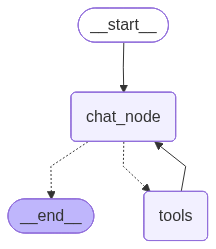

In [19]:
chatbot

In [21]:
result = chatbot.invoke(
    {
        "messages": [
            HumanMessage(
                content=(
                    "Using the pdf notes, explain how to find the ideal value of K in KNN"
                )
            )
        ]
    }
)


In [22]:
print(result['messages'][-1].content)

The ideal value of K in KNN (K-Nearest Neighbors) algorithm can vary depending on the specific problem and dataset. However, based on the provided text, it seems that a larger value of K (e.g. K = 9) can produce a smoother fit, while a smaller value of K (e.g. K = 1) can result in a rough step function.

In general, the choice of K has a significant impact on the KNN classifier and regression, and there is no one-size-fits-all answer for the ideal value of K. It is often necessary to experiment with different values of K and evaluate their performance on the specific problem at hand.
